# Fine-Tuning Sentence Embeddings for Customer Support Clustering

**Goal:** Fine-tune `all-MiniLM-L6-v2` with intent supervision so that utterances with the same intent are embedded closer together, improving downstream UMAP + HDBSCAN clustering.

**Dataset:** `bitext/Bitext-customer-support-llm-chatbot-training-dataset` (26,872 samples, 27 intents, 11 categories)

---

## Approach

| Step | What |
|------|------|
| 1 | Stratified train/val split (80/20 by intent) |
| 2 | Generate (anchor, positive) pairs from same-intent utterances |
| 3 | Fine-tune with `MultipleNegativesRankingLoss` (in-batch negatives) |
| 4 | Re-run UMAP → HDBSCAN pipeline on fine-tuned embeddings |
| 5 | Compare ARI/NMI against the base model baseline |

## 1. Setup & Imports

In [1]:
# All dependencies are managed via pyproject.toml + uv
# To install/sync:  uv sync
# To register the Jupyter kernel:
#   uv run python -m ipykernel install --user --name contact-center --display-name "Contact Center (Python 3.13)"
# Then select the "Contact Center (Python 3.13)" kernel in Jupyter.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, InputExample
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.evaluation import TripletEvaluator
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
import umap
import hdbscan
import random
import warnings

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (12, 6)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Libraries loaded. Device: {device}")

Libraries loaded. Device: mps


## 2. Load Data

In [3]:
dataset = load_dataset(
    "bitext/Bitext-customer-support-llm-chatbot-training-dataset",
    split="train"
)
df = dataset.to_pandas()

le_intent = LabelEncoder()
le_category = LabelEncoder()
df["intent_label"] = le_intent.fit_transform(df["intent"])
df["category_label"] = le_category.fit_transform(df["category"])

print(f"Loaded {df.shape[0]:,} rows")
print(f"Intents: {df['intent'].nunique()} | Categories: {df['category'].nunique()}")
print(f"\nSamples per intent:")
print(df["intent"].value_counts().describe().round(1))

Loaded 26,872 rows
Intents: 27 | Categories: 11

Samples per intent:
count      27.0
mean      995.3
std        10.4
min       950.0
25%       997.0
50%       998.0
75%       999.0
max      1000.0
Name: count, dtype: float64


## 3. Train / Validation Split

Stratified 80/20 split at the **utterance level** (not pair level). This ensures:
- Every intent is represented in both splits
- No utterance appears in both train and val pair sets (no leakage)

In [4]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["intent"],
    random_state=SEED
)

print(f"Train: {len(train_df):,} utterances")
print(f"Val:   {len(val_df):,} utterances")
print(f"\nTrain intents distribution (min/max): "
      f"{train_df['intent'].value_counts().min()} / {train_df['intent'].value_counts().max()}")
print(f"Val intents distribution (min/max): "
      f"{val_df['intent'].value_counts().min()} / {val_df['intent'].value_counts().max()}")

Train: 21,497 utterances
Val:   5,375 utterances

Train intents distribution (min/max): 760 / 800
Val intents distribution (min/max): 190 / 200


## 4. Generate Training Pairs

For `MultipleNegativesRankingLoss`, we need **(anchor, positive)** pairs where both utterances share the same intent. In-batch negatives are automatic.

**Pair sampling strategy:** For each intent, randomly sample up to 1,000 pairs from the set of all possible C(n, 2) combinations. With 27 intents this yields ~27,000 training pairs.

In [5]:
def generate_pairs(dataframe, pairs_per_intent=1000, seed=42):
    """Generate (anchor, positive) pairs from same-intent utterances."""
    rng = random.Random(seed)
    pairs = []

    for intent, group in dataframe.groupby("intent"):
        instructions = group["instruction"].tolist()
        n = len(instructions)

        if n < 2:
            continue

        total_possible = n * (n - 1) // 2
        if total_possible <= pairs_per_intent:
            for i in range(n):
                for j in range(i + 1, n):
                    pairs.append(InputExample(texts=[instructions[i], instructions[j]]))
        else:
            sampled = set()
            while len(sampled) < pairs_per_intent:
                i = rng.randint(0, n - 1)
                j = rng.randint(0, n - 1)
                if i != j:
                    key = (min(i, j), max(i, j))
                    sampled.add(key)
            for i, j in sampled:
                pairs.append(InputExample(texts=[instructions[i], instructions[j]]))

    rng.shuffle(pairs)
    return pairs


train_pairs = generate_pairs(train_df, pairs_per_intent=1000, seed=SEED)
print(f"Training pairs: {len(train_pairs):,}")
print(f"\nExample pair:")
print(f"  Anchor:   {train_pairs[0].texts[0][:100]}")
print(f"  Positive: {train_pairs[0].texts[1][:100]}")

Training pairs: 27,000

Example pair:
  Anchor:   help me recovering the password of my account
  Positive: I have got to retrieve my user account PIN


In [6]:
def generate_triplets(dataframe, triplets_per_intent=200, seed=42):
    """Generate (anchor, positive, negative) triplets for evaluation."""
    rng = random.Random(seed)
    anchors, positives, negatives = [], [], []

    intent_groups = {intent: group["instruction"].tolist()
                     for intent, group in dataframe.groupby("intent")}
    intent_list = list(intent_groups.keys())

    for intent in intent_list:
        instructions = intent_groups[intent]
        n = len(instructions)
        if n < 2:
            continue

        other_intents = [i for i in intent_list if i != intent]

        for _ in range(min(triplets_per_intent, n * (n - 1) // 2)):
            i, j = rng.sample(range(n), 2)
            neg_intent = rng.choice(other_intents)
            neg_text = rng.choice(intent_groups[neg_intent])

            anchors.append(instructions[i])
            positives.append(instructions[j])
            negatives.append(neg_text)

    return anchors, positives, negatives


val_anchors, val_positives, val_negatives = generate_triplets(
    val_df, triplets_per_intent=200, seed=SEED
)

evaluator = TripletEvaluator(
    anchors=val_anchors,
    positives=val_positives,
    negatives=val_negatives,
    name="val-triplet",
    batch_size=128
)

print(f"Validation triplets: {len(val_anchors):,}")

Validation triplets: 5,400


## 5. Fine-Tune the Model

**Loss:** `MultipleNegativesRankingLoss` — treats each (anchor, positive) pair in the batch as a positive match and all other positives in the batch as negatives (InfoNCE / in-batch negatives).

| Parameter | Value | Rationale |
|-----------|-------|-----------|
| Epochs | 3 | Standard for fine-tuning small models on moderate data |
| Batch size | 64 | Larger = more in-batch negatives = stronger signal |
| Learning rate | 2e-5 | Default for sentence-transformers fine-tuning |
| Warmup | 10% of steps | Smooth ramp-up for stability |
| Scheduler | WarmupLinear | Default scheduler |

In [7]:
MODEL_NAME = "all-MiniLM-L6-v2"
OUTPUT_DIR = "./finetuned-MiniLM-L6-v2-customer-support"

model_ft = SentenceTransformer(MODEL_NAME, device=device)
loss = MultipleNegativesRankingLoss(model_ft)

train_dataloader = DataLoader(train_pairs, shuffle=True, batch_size=64)

epochs = 3
warmup_steps = int(len(train_dataloader) * epochs * 0.1)
evaluation_steps = len(train_dataloader) // 2

print(f"Training steps per epoch: {len(train_dataloader)}")
print(f"Total training steps:     {len(train_dataloader) * epochs}")
print(f"Warmup steps:             {warmup_steps}")
print(f"Evaluation every:         {evaluation_steps} steps")
print(f"Device:                   {model_ft.device}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Training steps per epoch: 422
Total training steps:     1266
Warmup steps:             126
Evaluation every:         211 steps
Device:                   mps:0


In [8]:
%%time
model_ft.fit(
    train_objectives=[(train_dataloader, loss)],
    evaluator=evaluator,
    epochs=epochs,
    warmup_steps=warmup_steps,
    evaluation_steps=evaluation_steps,
    output_path=OUTPUT_DIR,
    save_best_model=True,
    optimizer_params={"lr": 2e-5},
    show_progress_bar=True,
)
print(f"\nTraining complete. Best model saved to: {OUTPUT_DIR}")

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Val-triplet Cosine Accuracy
211,No log,No log,0.999259
422,No log,No log,0.999630
633,1.552532,No log,0.999630
844,1.552532,No log,0.999815
1055,1.153060,No log,0.999815
1266,1.153060,No log,0.999815


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Training complete. Best model saved to: ./finetuned-MiniLM-L6-v2-customer-support
CPU times: user 1min 26s, sys: 26.2 s, total: 1min 52s
Wall time: 1min 48s


## 6. Generate Embeddings: Base vs Fine-Tuned

Embed all 26,872 utterances with both the original and fine-tuned models for comparison.

In [9]:
model_base = SentenceTransformer(MODEL_NAME, device=device)
model_finetuned = SentenceTransformer(OUTPUT_DIR, device=device)

instructions = df["instruction"].tolist()

print("Encoding with base model...")
emb_base = model_base.encode(instructions, show_progress_bar=True, batch_size=256)
print(f"  Base embeddings shape: {emb_base.shape}")

print("\nEncoding with fine-tuned model...")
emb_ft = model_finetuned.encode(instructions, show_progress_bar=True, batch_size=256)
print(f"  Fine-tuned embeddings shape: {emb_ft.shape}")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

Encoding with base model...


Batches:   0%|          | 0/105 [00:00<?, ?it/s]

  Base embeddings shape: (26872, 384)

Encoding with fine-tuned model...


Batches:   0%|          | 0/105 [00:00<?, ?it/s]

  Fine-tuned embeddings shape: (26872, 384)


## 7. Clustering Pipeline: UMAP + HDBSCAN (v2)

Running the same improved pipeline from `clustering_analysis_v2.ipynb` on both embedding sets:

| Improvement | What |
|-------------|------|
| **Precomputed NN graph** | `nearest_neighbors()` computed once, shared by both UMAP projections |
| **3D parameter sweep** | `min_cluster_size` x `min_samples` x `epsilon` (64 configs) |
| **DBCV selection** | Best config chosen by internal DBCV metric (no label leakage), constrained to <= 30 clusters |
| **Full-dataset eval** | Noise points assigned via `approximate_predict`; both excl-noise and full-dataset ARI/NMI reported |

In [ ]:
from umap.umap_ import nearest_neighbors


def run_clustering_pipeline(embeddings, random_state=SEED):
    """Run precomputed-NN UMAP (15d) → DBCV-swept HDBSCAN and return full results."""

    # 1. Precompute NN graph once (most expensive step)
    knn_indices, knn_dists, knn_forest = nearest_neighbors(
        embeddings, n_neighbors=15, metric="cosine", metric_kwds={},
        angular=True, random_state=np.random.RandomState(random_state), verbose=False
    )
    precomputed_knn = (knn_indices, knn_dists, knn_forest)

    # 2. Clustering UMAP (15d, reuses NN graph)
    reducer_cluster = umap.UMAP(
        n_components=15, n_neighbors=15, min_dist=0.0, metric="cosine",
        random_state=random_state, verbose=False, precomputed_knn=precomputed_knn
    )
    emb_umap = reducer_cluster.fit_transform(embeddings)

    # 3. DBCV-based parameter sweep (constrained to <= 30 clusters)
    sweep_results = []
    for mcs in [200, 500, 750, 1000]:
        for ms in [5, 10, 25, 50]:
            for eps in [0.0, 0.5, 1.0, 2.0]:
                c = hdbscan.HDBSCAN(
                    min_cluster_size=mcs, min_samples=ms, metric="euclidean",
                    cluster_selection_method="eom", cluster_selection_epsilon=eps,
                    gen_min_span_tree=True
                )
                labels = c.fit_predict(emb_umap)
                n_c = len(set(labels)) - (1 if -1 in labels else 0)
                sweep_results.append({
                    "min_cluster_size": mcs, "min_samples": ms, "epsilon": eps,
                    "n_clusters": n_c, "dbcv": c.relative_validity_
                })

    sweep_df = pd.DataFrame(sweep_results)
    feasible = sweep_df[sweep_df["n_clusters"] <= 30]
    if feasible.empty:
        raise RuntimeError("No configurations produced <= 30 clusters — expand the sweep grid.")
    best = feasible.loc[feasible["dbcv"].idxmax()]

    # 4. Final HDBSCAN with best config
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=int(best["min_cluster_size"]),
        min_samples=int(best["min_samples"]),
        metric="euclidean", cluster_selection_method="eom",
        cluster_selection_epsilon=float(best["epsilon"]),
        gen_min_span_tree=True, prediction_data=True
    )
    labels = clusterer.fit_predict(emb_umap)

    # 5. Visualization UMAP (2d, reuses NN graph)
    reducer_viz = umap.UMAP(
        n_components=2, n_neighbors=15, min_dist=0.1, metric="cosine",
        random_state=random_state, verbose=False, precomputed_knn=precomputed_knn
    )
    emb_2d = reducer_viz.fit_transform(embeddings)

    return {
        "labels": labels,
        "coords_2d": emb_2d,
        "emb_umap": emb_umap,
        "clusterer": clusterer,
        "dbcv": clusterer.relative_validity_,
        "best_params": {
            "min_cluster_size": int(best["min_cluster_size"]),
            "min_samples": int(best["min_samples"]),
            "epsilon": float(best["epsilon"])
        },
        "sweep_df": sweep_df
    }


def evaluate_clustering(result, df, label_col="intent_label"):
    """Compute ARI/NMI in both excl-noise and full-dataset modes."""
    labels = result["labels"]
    clusterer = result["clusterer"]
    emb_umap = result["emb_umap"]

    valid = labels != -1
    n_clusters = len(set(labels[valid]))
    n_noise = (~valid).sum()

    # Excl-noise metrics
    ari = adjusted_rand_score(df.loc[valid, label_col], labels[valid])
    nmi = normalized_mutual_info_score(df.loc[valid, label_col], labels[valid])

    # Full-dataset metrics (assign noise via approximate_predict)
    labels_full = labels.copy()
    noise_idx = np.where(labels_full == -1)[0]
    if len(noise_idx) > 0:
        approx_labels, _ = hdbscan.approximate_predict(clusterer, emb_umap[noise_idx])
        labels_full[noise_idx] = approx_labels
    ari_full = adjusted_rand_score(df[label_col], labels_full)
    nmi_full = normalized_mutual_info_score(df[label_col], labels_full)

    return {
        "n_clusters": n_clusters,
        "noise_pct": round(n_noise / len(labels) * 100, 1),
        "ari": round(ari, 4),
        "nmi": round(nmi, 4),
        "ari_full": round(ari_full, 4),
        "nmi_full": round(nmi_full, 4),
        "dbcv": round(result["dbcv"], 4),
        "n_valid": valid.sum(),
        "best_params": result["best_params"],
        "labels_full": labels_full
    }

In [ ]:
%%time
print("Clustering BASE embeddings (64-config DBCV sweep)...")
result_base = run_clustering_pipeline(emb_base)
labels_base = result_base["labels"]
coords_base = result_base["coords_2d"]
p = result_base["best_params"]
print(f"  Best: mcs={p['min_cluster_size']}, ms={p['min_samples']}, eps={p['epsilon']}, "
      f"DBCV={result_base['dbcv']:.4f}")

print("\nClustering FINE-TUNED embeddings (64-config DBCV sweep)...")
result_ft = run_clustering_pipeline(emb_ft)
labels_ft = result_ft["labels"]
coords_ft = result_ft["coords_2d"]
p = result_ft["best_params"]
print(f"  Best: mcs={p['min_cluster_size']}, ms={p['min_samples']}, eps={p['epsilon']}, "
      f"DBCV={result_ft['dbcv']:.4f}")

print("\nDone.")

## 8. Evaluation: Base vs Fine-Tuned

In [ ]:
base_intent = evaluate_clustering(result_base, df, "intent_label")
ft_intent = evaluate_clustering(result_ft, df, "intent_label")

base_cat = evaluate_clustering(result_base, df, "category_label")
ft_cat = evaluate_clustering(result_ft, df, "category_label")

results = pd.DataFrame({
    "Metric": [
        "DBCV (internal)",
        "ARI vs Intent (excl. noise)", "NMI vs Intent (excl. noise)",
        "ARI vs Intent (full dataset)", "NMI vs Intent (full dataset)",
        "ARI vs Category (excl. noise)", "NMI vs Category (excl. noise)",
        "ARI vs Category (full dataset)", "NMI vs Category (full dataset)",
        "Clusters Found", "Noise %"
    ],
    "Base Model": [
        base_intent["dbcv"],
        base_intent["ari"], base_intent["nmi"],
        base_intent["ari_full"], base_intent["nmi_full"],
        base_cat["ari"], base_cat["nmi"],
        base_cat["ari_full"], base_cat["nmi_full"],
        base_intent["n_clusters"], base_intent["noise_pct"]
    ],
    "Fine-Tuned": [
        ft_intent["dbcv"],
        ft_intent["ari"], ft_intent["nmi"],
        ft_intent["ari_full"], ft_intent["nmi_full"],
        ft_cat["ari"], ft_cat["nmi"],
        ft_cat["ari_full"], ft_cat["nmi_full"],
        ft_intent["n_clusters"], ft_intent["noise_pct"]
    ],
})
results["Delta"] = results["Fine-Tuned"] - results["Base Model"]
results["Delta"] = results["Delta"].map(lambda x: f"+{x:.4f}" if x > 0 else f"{x:.4f}")

print("=" * 75)
print("  BASE vs FINE-TUNED MODEL — CLUSTERING METRICS (v2 pipeline)")
print("=" * 75)
print(f"\n  Base params:  {base_intent['best_params']}")
print(f"  FT params:    {ft_intent['best_params']}\n")
results

## 9. Visualization: Side-by-Side UMAP Plots

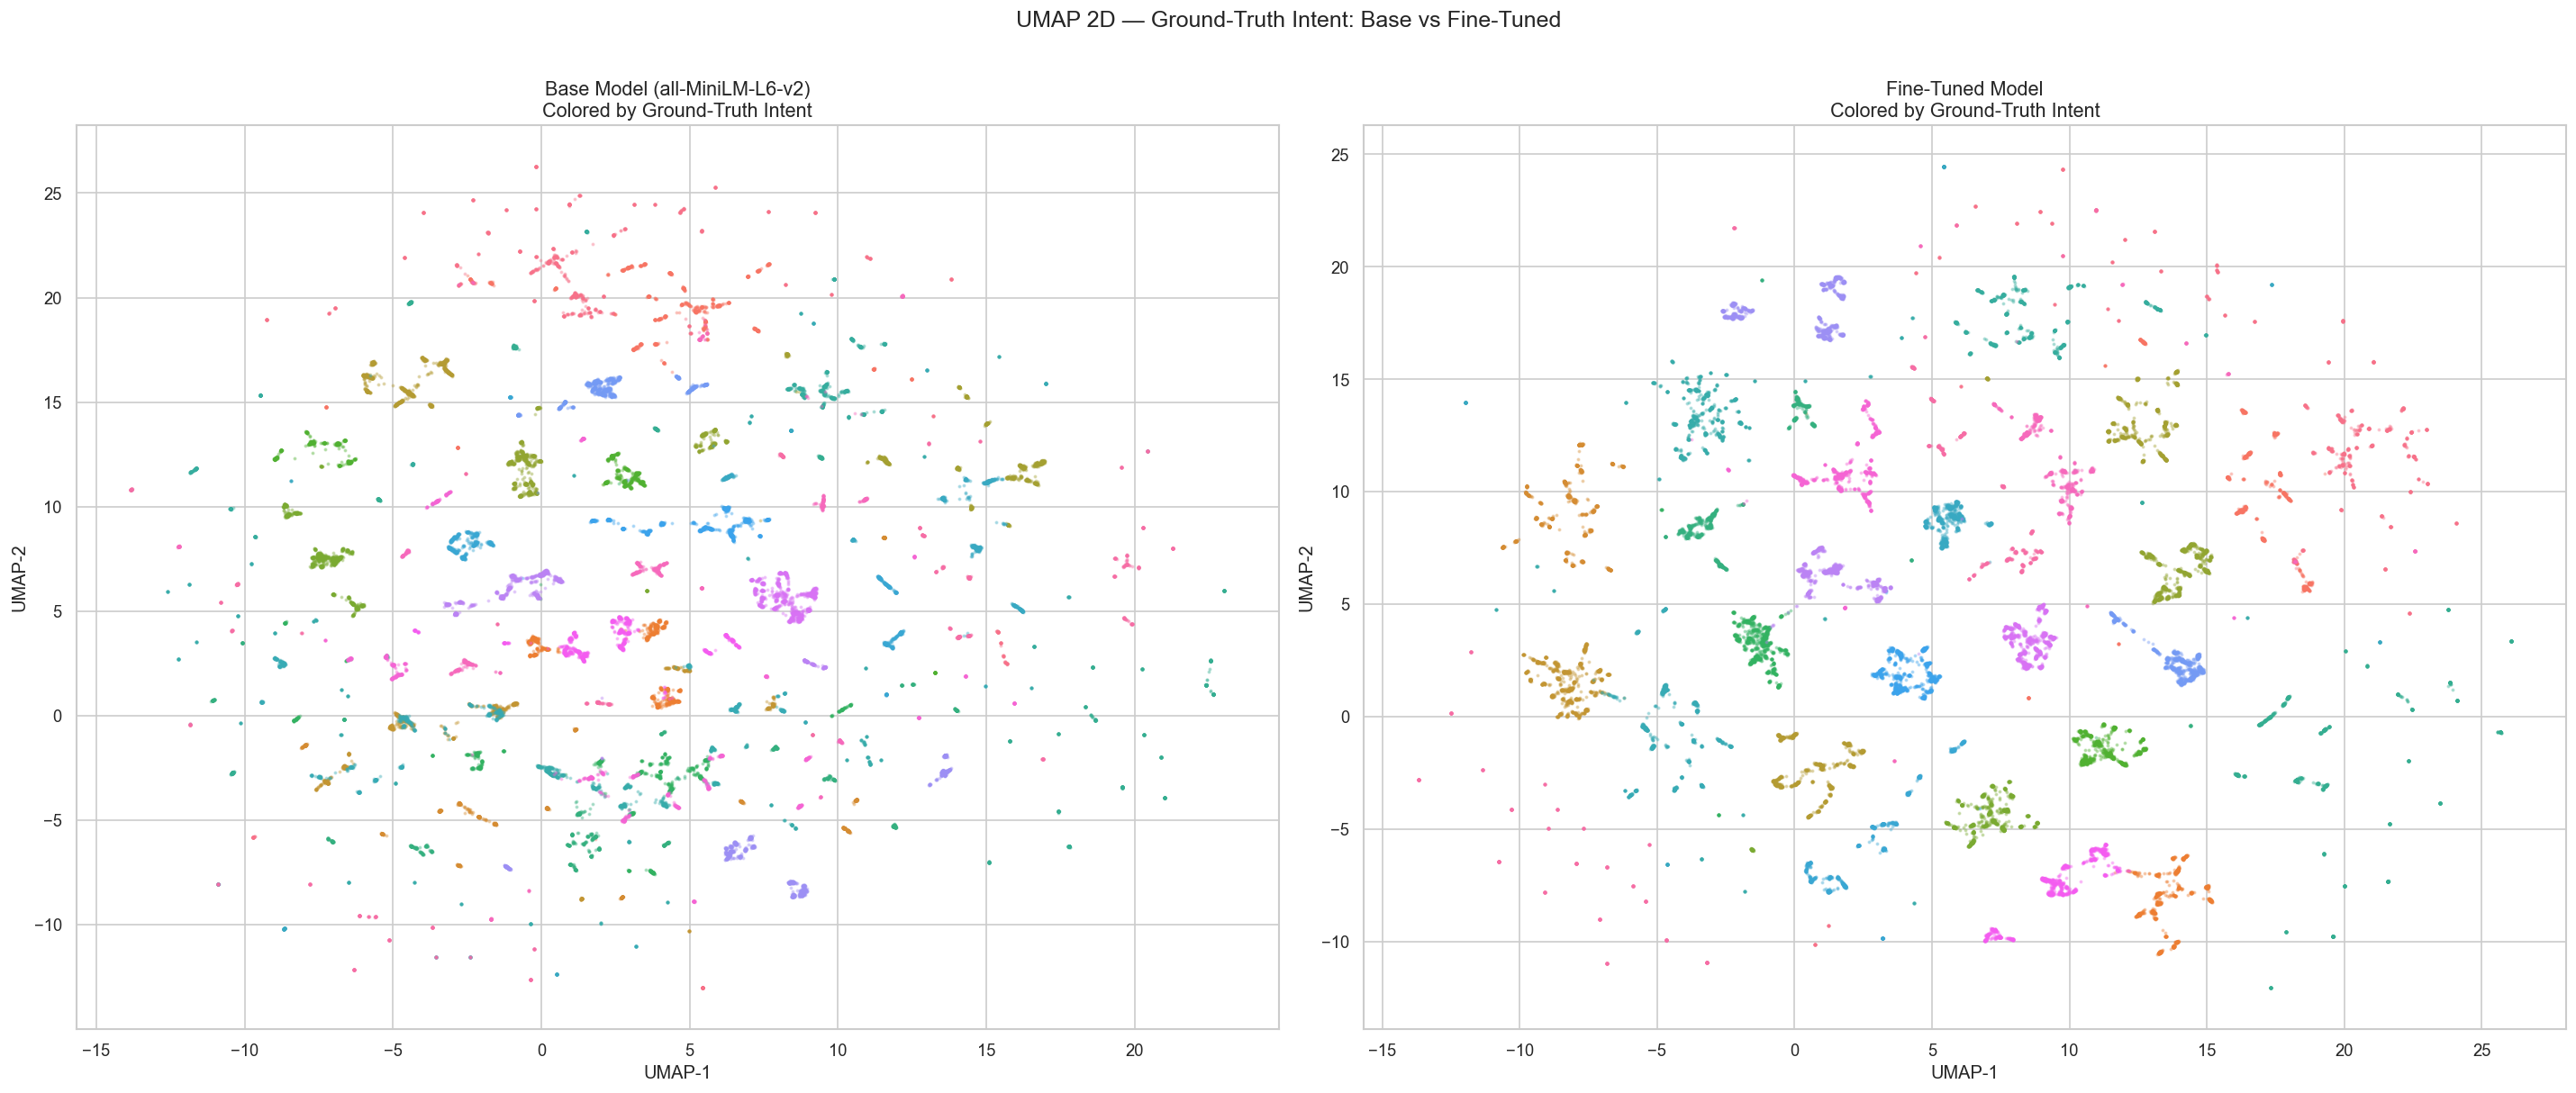

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

intents_sorted = sorted(df["intent"].unique())
palette_gt = sns.color_palette("husl", len(intents_sorted))

for ax_idx, (coords, title) in enumerate([
    (coords_base, "Base Model (all-MiniLM-L6-v2)"),
    (coords_ft, "Fine-Tuned Model")
]):
    ax = axes[ax_idx]
    for i, intent in enumerate(intents_sorted):
        mask = df["intent"] == intent
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=[palette_gt[i]], s=2, alpha=0.3)
    ax.set_title(f"{title}\nColored by Ground-Truth Intent", fontsize=13)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.suptitle("UMAP 2D — Ground-Truth Intent: Base vs Fine-Tuned", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

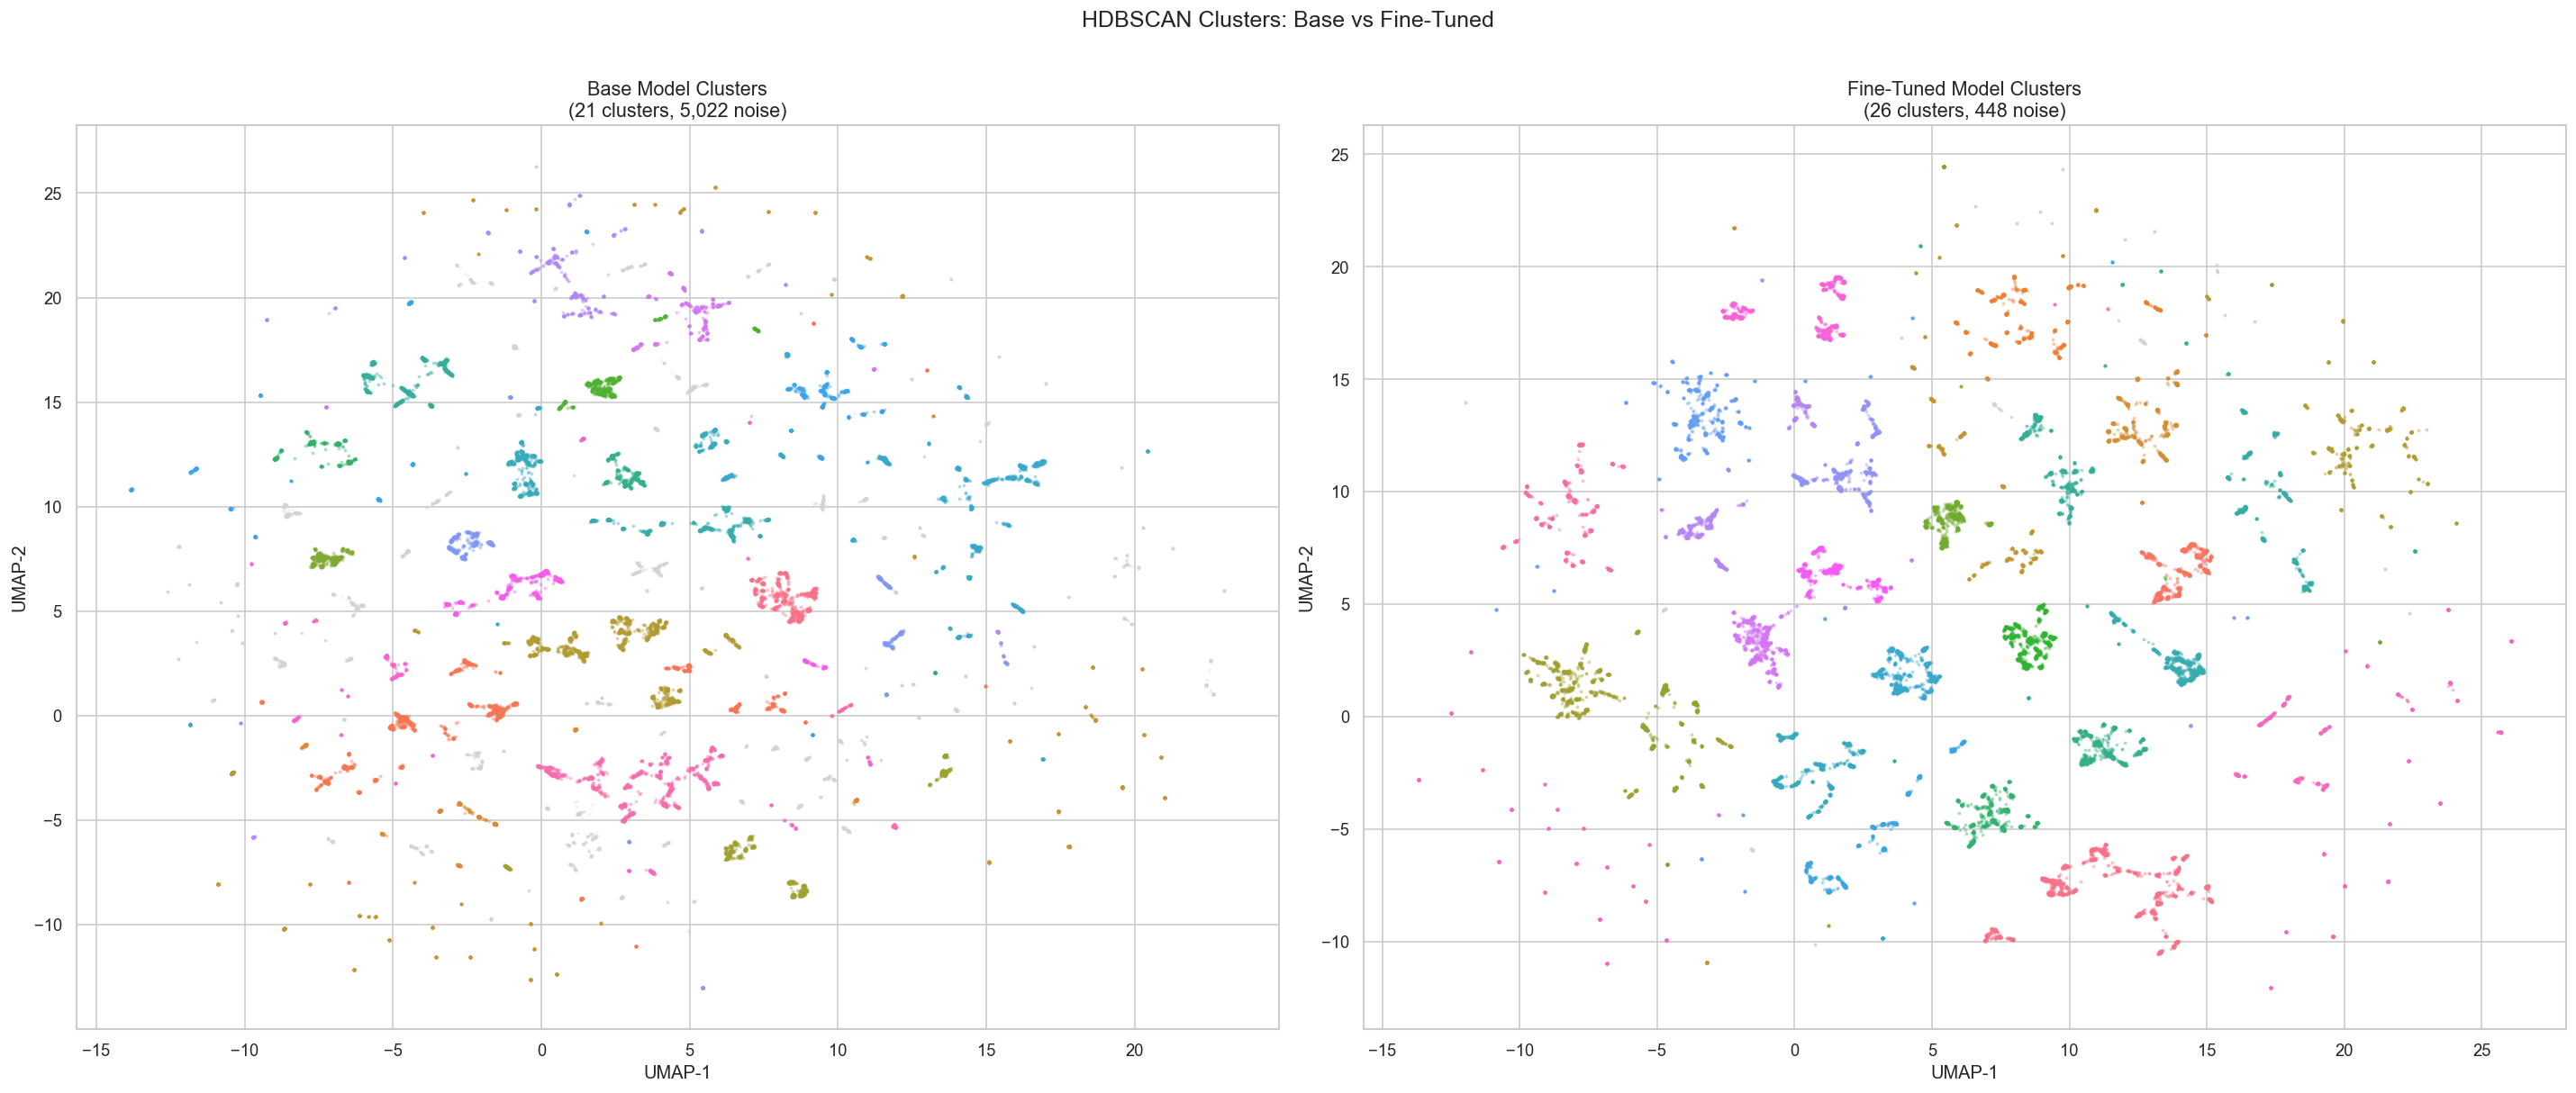

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(24, 10))

for ax_idx, (coords, labels, title) in enumerate([
    (coords_base, labels_base, "Base Model Clusters"),
    (coords_ft, labels_ft, "Fine-Tuned Model Clusters")
]):
    ax = axes[ax_idx]
    noise_mask = labels == -1
    non_noise_ids = sorted(set(labels[~noise_mask]))
    palette = sns.color_palette("husl", len(non_noise_ids))

    if noise_mask.any():
        ax.scatter(coords[noise_mask, 0], coords[noise_mask, 1],
                   c="lightgrey", s=1, alpha=0.2)

    for i, cid in enumerate(non_noise_ids):
        mask = labels == cid
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=[palette[i]], s=2, alpha=0.3)

    n_c = len(non_noise_ids)
    n_noise = noise_mask.sum()
    ax.set_title(f"{title}\n({n_c} clusters, {n_noise:,} noise)", fontsize=13)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

plt.suptitle("HDBSCAN Clusters: Base vs Fine-Tuned", fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

metric_labels = ["Intent", "Category"]
x = np.arange(len(metric_labels))
w = 0.35

# ARI comparison (full dataset)
ax = axes[0]
base_ari = [base_intent["ari_full"], base_cat["ari_full"]]
ft_ari = [ft_intent["ari_full"], ft_cat["ari_full"]]
bars1 = ax.bar(x - w/2, base_ari, w, label="Base", color="#4C72B0", alpha=0.8)
bars2 = ax.bar(x + w/2, ft_ari, w, label="Fine-Tuned", color="#DD8452", alpha=0.8)
ax.set_ylabel("ARI")
ax.set_title("ARI (Full Dataset)")
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.set_ylim(0, 1)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)

# NMI comparison (full dataset)
ax = axes[1]
base_nmi = [base_intent["nmi_full"], base_cat["nmi_full"]]
ft_nmi = [ft_intent["nmi_full"], ft_cat["nmi_full"]]
bars1 = ax.bar(x - w/2, base_nmi, w, label="Base", color="#4C72B0", alpha=0.8)
bars2 = ax.bar(x + w/2, ft_nmi, w, label="Fine-Tuned", color="#DD8452", alpha=0.8)
ax.set_ylabel("NMI")
ax.set_title("NMI (Full Dataset)")
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.legend()
ax.set_ylim(0, 1)
for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)
for bar in bars2:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)

# DBCV comparison
ax = axes[2]
dbcv_vals = [base_intent["dbcv"], ft_intent["dbcv"]]
model_labels = ["Base", "Fine-Tuned"]
colors = ["#4C72B0", "#DD8452"]
bars = ax.bar(model_labels, dbcv_vals, color=colors, alpha=0.8, width=0.5)
ax.set_ylabel("DBCV")
ax.set_title("DBCV (Internal Validity)")
ax.set_ylim(0, 1)
for bar in bars:
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f"{bar.get_height():.4f}", ha="center", va="bottom", fontsize=9)

plt.suptitle("Clustering Quality: Base vs Fine-Tuned (v2 Pipeline)", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 10. Per-Intent Purity Comparison

For each ground-truth intent, compute the fraction of its samples that land in the single most common cluster. Uses **full-dataset** labels (noise assigned via `approximate_predict`) for a fair comparison.

In [ ]:
def compute_purity(labels, intents):
    """Per-intent cluster purity (fraction in dominant cluster), full dataset."""
    purity = {}
    for intent in intents.unique():
        mask = intents == intent
        counts = pd.Series(labels[mask]).value_counts()
        purity[intent] = counts.iloc[0] / counts.sum()
    return pd.Series(purity).sort_values()


purity_base = compute_purity(base_intent["labels_full"], df["intent"])
purity_ft = compute_purity(ft_intent["labels_full"], df["intent"])

purity_compare = pd.DataFrame({
    "Base": purity_base,
    "Fine-Tuned": purity_ft
}).sort_values("Base")

fig, ax = plt.subplots(figsize=(12, 8))
y = np.arange(len(purity_compare))
h = 0.35
ax.barh(y - h/2, purity_compare["Base"], h, label="Base", color="#4C72B0", alpha=0.8)
ax.barh(y + h/2, purity_compare["Fine-Tuned"], h, label="Fine-Tuned", color="#DD8452", alpha=0.8)
ax.set_yticks(y)
ax.set_yticklabels(purity_compare.index, fontsize=9)
ax.set_xlabel("Purity (fraction in dominant cluster)")
ax.set_title("Per-Intent Cluster Purity: Base vs Fine-Tuned (Full Dataset)")
ax.axvline(x=purity_base.mean(), color="#4C72B0", linestyle="--", alpha=0.5,
           label=f"Base mean = {purity_base.mean():.3f}")
ax.axvline(x=purity_ft.mean(), color="#DD8452", linestyle="--", alpha=0.5,
           label=f"FT mean = {purity_ft.mean():.3f}")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"Base purity:       mean={purity_base.mean():.3f}, min={purity_base.min():.3f}")
print(f"Fine-tuned purity: mean={purity_ft.mean():.3f}, min={purity_ft.min():.3f}")

## 11. Embedding Space Analysis

Compare how tightly the fine-tuned model groups same-intent utterances by looking at intra-class vs inter-class cosine similarity.

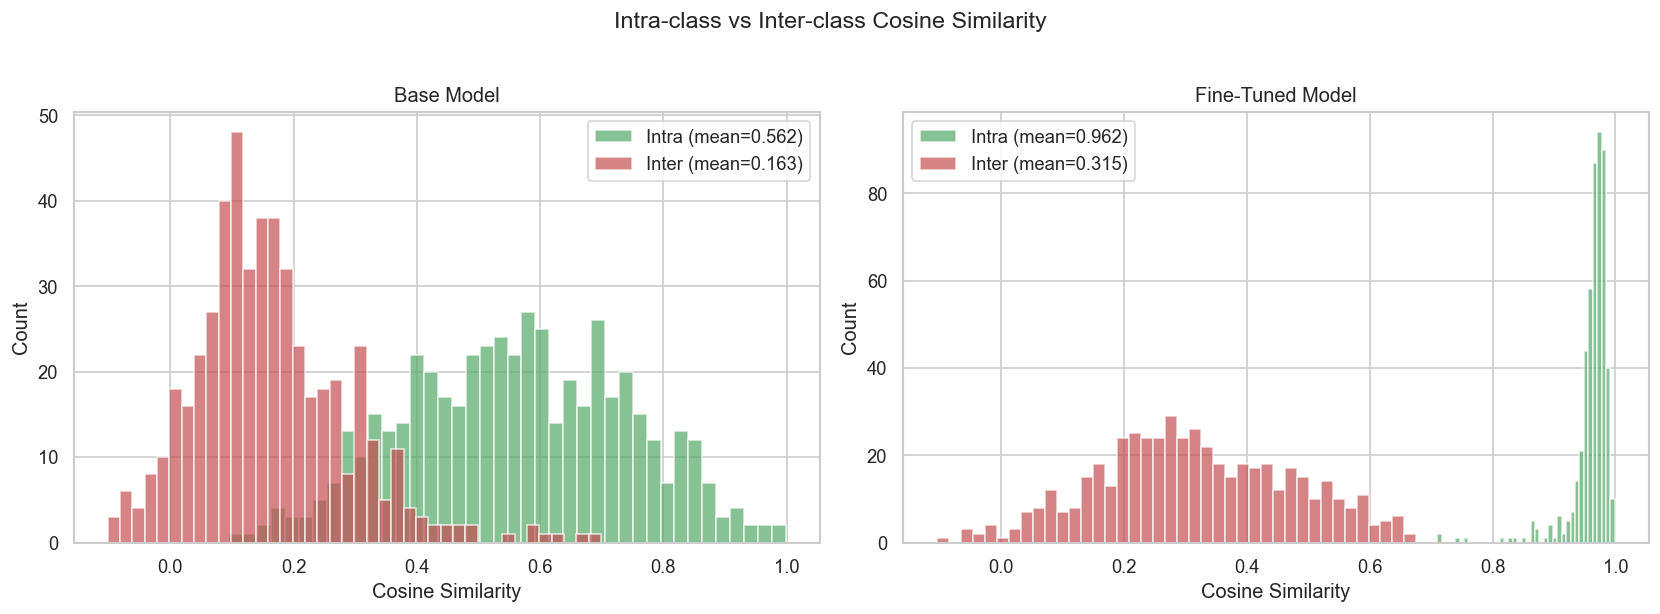

Separation (intra_mean - inter_mean):
  Base:       0.3987
  Fine-tuned: 0.6471
  Delta:      +0.2484


In [17]:
from sentence_transformers.util import cos_sim


def compute_similarity_stats(embeddings, intents, n_samples=500, seed=42):
    """Sample intra-class and inter-class cosine similarities."""
    rng = random.Random(seed)
    intent_indices = {}
    for idx, intent in enumerate(intents):
        intent_indices.setdefault(intent, []).append(idx)

    intra_sims, inter_sims = [], []
    intent_list = list(intent_indices.keys())

    for _ in range(n_samples):
        intent = rng.choice(intent_list)
        i, j = rng.sample(intent_indices[intent], 2)
        sim = float(cos_sim(embeddings[i:i+1], embeddings[j:j+1]))
        intra_sims.append(sim)

        int_a, int_b = rng.sample(intent_list, 2)
        i = rng.choice(intent_indices[int_a])
        j = rng.choice(intent_indices[int_b])
        sim = float(cos_sim(embeddings[i:i+1], embeddings[j:j+1]))
        inter_sims.append(sim)

    return intra_sims, inter_sims


intra_base, inter_base = compute_similarity_stats(emb_base, df["intent"].tolist())
intra_ft, inter_ft = compute_similarity_stats(emb_ft, df["intent"].tolist())

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.hist(intra_base, bins=40, alpha=0.7, label=f"Intra (mean={np.mean(intra_base):.3f})", color="#55A868")
ax.hist(inter_base, bins=40, alpha=0.7, label=f"Inter (mean={np.mean(inter_base):.3f})", color="#C44E52")
ax.set_title("Base Model")
ax.set_xlabel("Cosine Similarity")
ax.set_ylabel("Count")
ax.legend()

ax = axes[1]
ax.hist(intra_ft, bins=40, alpha=0.7, label=f"Intra (mean={np.mean(intra_ft):.3f})", color="#55A868")
ax.hist(inter_ft, bins=40, alpha=0.7, label=f"Inter (mean={np.mean(inter_ft):.3f})", color="#C44E52")
ax.set_title("Fine-Tuned Model")
ax.set_xlabel("Cosine Similarity")
ax.set_ylabel("Count")
ax.legend()

plt.suptitle("Intra-class vs Inter-class Cosine Similarity", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

sep_base = np.mean(intra_base) - np.mean(inter_base)
sep_ft = np.mean(intra_ft) - np.mean(inter_ft)
print(f"Separation (intra_mean - inter_mean):")
print(f"  Base:       {sep_base:.4f}")
print(f"  Fine-tuned: {sep_ft:.4f}")
print(f"  Delta:      +{sep_ft - sep_base:.4f}")

## 12. Summary

In [ ]:
print("=" * 75)
print("  FINE-TUNING RESULTS SUMMARY (v2 Pipeline)")
print("=" * 75)
print(f"  Base model:            {MODEL_NAME}")
print(f"  Fine-tuned model:      {OUTPUT_DIR}")
print(f"  Training pairs:        {len(train_pairs):,}")
print(f"  Epochs:                {epochs}")
print(f"  Batch size:            64")
print(f"  Loss:                  MultipleNegativesRankingLoss")
print(f"  ───────────────────────────────────────────────────────────────────")
print(f"  Base HDBSCAN params:   {base_intent['best_params']}")
print(f"  FT HDBSCAN params:     {ft_intent['best_params']}")
print(f"  ───────────────────────────────────────────────────────────────────")
print(f"  {'Metric':<35} {'Base':>8} {'Fine-Tuned':>10} {'Delta':>8}")
print(f"  ───────────────────────────────────────────────────────────────────")
print(f"  {'DBCV (internal)':<35} {base_intent['dbcv']:>8.4f} {ft_intent['dbcv']:>10.4f} {ft_intent['dbcv']-base_intent['dbcv']:>+8.4f}")
print(f"  {'ARI vs Intent (excl. noise)':<35} {base_intent['ari']:>8.4f} {ft_intent['ari']:>10.4f} {ft_intent['ari']-base_intent['ari']:>+8.4f}")
print(f"  {'NMI vs Intent (excl. noise)':<35} {base_intent['nmi']:>8.4f} {ft_intent['nmi']:>10.4f} {ft_intent['nmi']-base_intent['nmi']:>+8.4f}")
print(f"  {'ARI vs Intent (full dataset)':<35} {base_intent['ari_full']:>8.4f} {ft_intent['ari_full']:>10.4f} {ft_intent['ari_full']-base_intent['ari_full']:>+8.4f}")
print(f"  {'NMI vs Intent (full dataset)':<35} {base_intent['nmi_full']:>8.4f} {ft_intent['nmi_full']:>10.4f} {ft_intent['nmi_full']-base_intent['nmi_full']:>+8.4f}")
print(f"  {'ARI vs Category (excl. noise)':<35} {base_cat['ari']:>8.4f} {ft_cat['ari']:>10.4f} {ft_cat['ari']-base_cat['ari']:>+8.4f}")
print(f"  {'NMI vs Category (excl. noise)':<35} {base_cat['nmi']:>8.4f} {ft_cat['nmi']:>10.4f} {ft_cat['nmi']-base_cat['nmi']:>+8.4f}")
print(f"  {'ARI vs Category (full dataset)':<35} {base_cat['ari_full']:>8.4f} {ft_cat['ari_full']:>10.4f} {ft_cat['ari_full']-base_cat['ari_full']:>+8.4f}")
print(f"  {'NMI vs Category (full dataset)':<35} {base_cat['nmi_full']:>8.4f} {ft_cat['nmi_full']:>10.4f} {ft_cat['nmi_full']-base_cat['nmi_full']:>+8.4f}")
print(f"  {'Clusters Found':<35} {base_intent['n_clusters']:>8d} {ft_intent['n_clusters']:>10d} {ft_intent['n_clusters']-base_intent['n_clusters']:>+8d}")
print(f"  {'Noise %':<35} {base_intent['noise_pct']:>7.1f}% {ft_intent['noise_pct']:>9.1f}% {ft_intent['noise_pct']-base_intent['noise_pct']:>+7.1f}%")
print(f"  {'Mean Purity (full dataset)':<35} {purity_base.mean():>8.3f} {purity_ft.mean():>10.3f} {purity_ft.mean()-purity_base.mean():>+8.3f}")
print(f"  {'Embedding Separation':<35} {sep_base:>8.4f} {sep_ft:>10.4f} {sep_ft-sep_base:>+8.4f}")
print("=" * 75)